In [32]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime as dt
from scipy.signal import lfilter
import pickle as pickle

### JH Time Series Data

* Time series data is cumlative per column

In [2]:
date_start = '01/23/20'
date_up_to = '10/29/20'
jh_path = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
confirmed_global = 'time_series_covid19_confirmed_global.csv'
deaths_global = 'time_series_covid19_deaths_global.csv'

confirmed = pd.read_csv(jh_path+confirmed_global)
deaths = pd.read_csv(jh_path+deaths_global)

#Need to adjust country names to match those in CNCB
confirmed.loc[confirmed['Country/Region']=='US','Country/Region'] = 'United States'
confirmed.loc[confirmed['Country/Region']=='Congo (Kinshasa)','Country/Region'] = 'Democratic Republic of the Congo'
confirmed.loc[confirmed['Country/Region']=='Korea, South','Country/Region'] = 'South Korea'
confirmed.loc[confirmed['Country/Region']=='Czechia','Country/Region'] = 'Czech Republic'
confirmed.loc[confirmed['Country/Region']=='Burma','Country/Region'] = 'myanmar'
confirmed.loc[confirmed['Country/Region']=='Congo (Brazzaville)','Country/Region'] = 'republic of the congo'

confirmed['Country/Region'] = confirmed['Country/Region'].str.lower()
confirmed.set_index('Country/Region',inplace=True)


deaths.loc[deaths['Country/Region']=='US','Country/Region'] = 'United States'
deaths.loc[deaths['Country/Region']=='Congo (Kinshasa)','Country/Region'] = 'Democratic Republic of the Congo'
deaths.loc[deaths['Country/Region']=='Korea, South','Country/Region'] = 'South Korea'
deaths.loc[deaths['Country/Region']=='Czechia','Country/Region'] = 'Czech Republic'
deaths.loc[deaths['Country/Region']=='Burma','Country/Region'] = 'myanmar'
deaths.loc[deaths['Country/Region']=='Congo (Brazzaville)','Country/Region'] = 'republic of the congo'

deaths['Country/Region'] = deaths['Country/Region'].str.lower()
deaths.set_index('Country/Region',inplace=True)

### Need other data table for population number
* doesn't matter for date as long as all the countries are covered, only getting population number

In [3]:
date = '10-29-2020.csv'
jh_path = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
jh_data = pd.read_csv(jh_path+date)

#drop rows that have nans for incidence rate
jh_data = jh_data[~jh_data['Incidence_Rate'].isnull()]
jh_data = jh_data[jh_data['Incidence_Rate']!=0]

#matching countries of jh data to that of cncb countries
jh_data.loc[jh_data['Country_Region']=='Taiwan*','Country_Region'] = 'Taiwan'
jh_data.loc[jh_data['Country_Region']=='US','Country_Region'] = 'United States'
jh_data.loc[jh_data['Country_Region']=='Korea, South','Country_Region'] = 'South Korea'
jh_data.loc[jh_data['Country_Region']=='Czechia','Country_Region'] = 'Czech Republic'
jh_data.loc[jh_data['Country_Region']=='Burma','Country_Region'] = 'myanmar'
jh_data.loc[jh_data['Country_Region']=='Congo (Kinshasa)','Country_Region'] = 'Democratic Republic of the Congo'
jh_data.loc[jh_data['Country_Region']=='Congo (Brazzaville)','Country_Region'] = 'republic of the congo'

jh_data['Population'] = jh_data['Confirmed']/jh_data['Incidence_Rate']*100000
jh_data['Country_Region'] = jh_data['Country_Region'].str.lower()

### CNCB Genome Meta Data

In [4]:
#cncb meta, need to match countries
column_names = ['Virus Strain Name','Accession ID','Related ID','Nuc.Completeness','Sequence Quality','Host','Location','Sample Collection Date','Submitting Lab']
meta = pd.read_excel('../metadata10_27.xlsx',usecols=column_names,index_col=1)
meta.fillna(' ',inplace=True)
meta['Country'] = meta['Location'].str.split('/').str[0].str.strip()
meta.loc[meta['Country']=='\u200eRomania','Country'] = 'Romania'
#Remove low quality and partial reads, pretty sure cncb does not run variant annotation for these anyways
meta = meta[meta['Sequence Quality']!='Low']
meta = meta[meta['Nuc.Completeness']!='Partial']
meta['Country'] = meta['Country'].str.lower()

#Filter using date as well
meta = meta[meta['Sample Collection Date']!='2020-00-00'] #bad dates in there
meta.loc[:,'Sample Collection Date'] = pd.to_datetime(meta['Sample Collection Date'], yearfirst=True)
dt_date_up_to = dt.strptime(date_up_to, "%m/%d/%y")
dt_date_start = dt.strptime(date_start, "%m/%d/%y")
meta = meta[(meta.loc[:,'Sample Collection Date']<dt_date_up_to) & (meta.loc[:,'Sample Collection Date']>dt_date_start)]

print(meta.shape)

(91387, 9)


### If there is a missing country in set difference, there will be nan data in output

In [5]:
set(meta['Country'])-set(confirmed.index.str.lower())

set()

In [6]:
len(set(meta['Country']))

109

### Using Infections per 100k and Fatality percentage
* Create IR/FR for all days. Cumlative up to that day.

In [12]:
jh_daily_ir = pd.DataFrame(columns=pd.to_datetime(confirmed.columns[4::])) #start from the second date because we take difference between dates
jh_daily_fr = pd.DataFrame(columns=pd.to_datetime(confirmed.columns[4::]))
country_daily_cts = pd.DataFrame(columns=pd.to_datetime(confirmed.columns[4::]))
country_death_cts = pd.DataFrame(columns=pd.to_datetime(confirmed.columns[4::]))

jh_country_lvl = pd.DataFrame(columns=['cases','deaths','population'])

for country in set(meta['Country'].str.lower()):
    population = jh_data.loc[jh_data['Country_Region']==country,'Population'].sum()
    summed_cases = confirmed.loc[confirmed.index==country,date_up_to].sum()
    summed_deaths = deaths.loc[deaths.index==country,date_up_to].sum()
    jh_country_lvl.loc[country] = [summed_cases,summed_deaths,population]
    
    cases_timeperiod = 1+confirmed.loc[confirmed.index==country].iloc[:,4::].sum().values
    deaths_timeperiod = deaths.loc[deaths.index==country].iloc[:,4::].sum().values
    jh_daily_ir.loc[country] = cases_timeperiod / population * 100000
    jh_daily_fr.loc[country] = np.nan_to_num(deaths_timeperiod / cases_timeperiod) * 100 #replaces nan with 0 and inf with large finite numbers
    country_daily_cts.loc[country] = (confirmed.loc[[country]].iloc[:,4::].sum().values-confirmed.loc[[country]].iloc[:,3:-1].sum().values).clip(min=0)
    country_death_cts.loc[country] = (deaths.loc[[country]].iloc[:,4::].sum().values-deaths.loc[[country]].iloc[:,3:-1].sum().values).clip(min=0)

jh_country_lvl.sort_index(inplace=True)
jh_daily_ir.sort_index(inplace=True)
jh_daily_fr.sort_index(inplace=True)

In [27]:
# jh_daily_ir.to_csv(f"temporal_files/daily_counts/daily_ir.csv")
# jh_daily_fr.to_csv(f"temporal_files/daily_counts/daily_fr.csv")
# country_daily_cts.to_csv(f"temporal_files/daily_counts/daily_cases.csv")
# country_death_cts.to_csv(f"temporal_files/daily_counts/daily_deaths.csv")

### Parsing gff3 files
* Change to only parse files that aren't in collection of variants. Load a saved file with collect values and which gff3 files, only update.
* aggregated_mutations contain for each day, mutation identifier and countries listed, need to count countries to get totals
* processed_identifiers contain sequence identifier from meta file, do not have to reprocess those that are already used

In [21]:
with open(f"jh_cncb_daily_dates.pkl",'rb') as file: #Contains only country name for each date
    aggregated_mutations = pickle.load(file)
    
with open(f"jh_cncb_daily_dates_identifiers.pkl",'rb') as file:
    processed_identifiers = pickle.load(file)

In [28]:
all_names = os.listdir('../gff3_cncb_restructured')
column_names = ['variant type','start','end', 'info']
missing = []
date_range = pd.date_range(start=jh_daily_ir.columns[0], end=jh_daily_ir.columns[-1])

#Check if there is a processesd_identifier list, contains genome names already processed
if 'processed_identifiers' not in locals():
    processed_identifiers = []
    
#aggregated mutations, dictionary for each date, each sub dictionary contains a 3d list structure. [[],[],[]]
if 'aggregated_mutations' not in locals():
    #this is for country ir and fr for that specific day
    aggregated_mutations = {date:{} for date in date_range}

#for identifier in tqdm(meta[meta['Country']=='United States'].index):
for identifier in tqdm(meta.index):
    
    #Use prexisting list
    if identifier in processed_identifiers:
        continue
        
    #Searching for correct identifier
    #--------------------------
    #No alternate name is ' '
    file_name = ''
    #Check if accession id in file names, if not check related ids
    if '2019-nCoV_'+identifier+'_variants.gff3' in all_names:
        file_name = '2019-nCoV_'+identifier+'_variants.gff3'
    # checking alternate names
    elif meta.loc[identifier,'Related ID'] != ' ':
        for alt_identifier in meta.loc[identifier,'Related ID'].replace(' ','').split(','):
            if '2019-nCoV_'+alt_identifier+'_variants.gff3' in all_names:
                file_name = '2019-nCoV_'+alt_identifier+'_variants.gff3'
                break
        #Added in case alternate names are also not found in gffs
        if file_name == '':
            missing.append(identifier)
            continue
    # If file name has not been updated, then there is no matching identifier, move to next index
    elif file_name == '':
        missing.append(identifier)
        continue
    #--------------------------
    
    #Filtering files with no variants
    #--------------------------
    with open(f'../gff3_cncb_restructured/{file_name}') as text_file:
        lines = text_file.readlines()
        counter = 0
        for l in lines:
            if '#' in l:
                counter += 1
    #Number of info lines should be less than total, if not then there are no mutations
    #--------------------------
    
    #List to keep track of which files used already, save and import this in future to avoid redundant search
    processed_identifiers.append(identifier)
    
    if counter<len(lines) and meta.loc[identifier,'Country'] in set(jh_data['Country_Region']): #country needs to be found in jh data for inf/fata rates
        
        gff = pd.read_csv(f'../gff3_cncb_restructured/{file_name}',sep='\t',skiprows=counter,usecols=[1,3,4,8],names=column_names)
        info_df = pd.DataFrame(gff['info'].str.split(';').values.tolist(),columns=[0,1,'Ref','Alt','Description']).drop([0,1],axis=1)
        gff = gff.drop(['info'],axis=1)
        gff['Country'] = [meta.loc[identifier,'Country']]*gff.shape[0]
        temp_df = pd.concat([gff,info_df],axis=1)
        
        #Filtering alternate amino acid and reference for missense_variant and synonymous_variant
        missenses_ref = temp_df.loc[temp_df['Description'].str.contains('missense_variant'),'Description'].str.split(',').str[1].str[-3]
        synonymous_ref = temp_df.loc[temp_df['Description'].str.contains('synonymous_variant'),'Description'].str.split(',').str[1].str[-1]
        temp_df['Ref_AA'] = pd.concat([missenses_ref,synonymous_ref])
        temp_df['Alt_AA'] = temp_df.loc[temp_df['Description'].str.contains('missense_variant'),'Description'].str.split(',').str[1].str[-1]

        missenses_str = temp_df.loc[temp_df['Description'].str.contains('missense_variant'),'Description'].str.split(',').str[1].str.split('.').str[-1]
        synonymous_str = temp_df.loc[temp_df['Description'].str.contains('synonymous_variant'),'Description'].str.split(',').str[1].str.split('.').str[-1]
        temp_df['AA'] = pd.concat([missenses_str,synonymous_str])
        
        temp_df.fillna('', inplace=True)
        temp_df['descriptor'] = temp_df['start'].astype(str)+','+temp_df['end'].astype(str)+','+temp_df['Ref']+','+temp_df['Alt']+\
        ','+temp_df['Description'].str.split(',').str[0].str.split('=').str[1]+','+temp_df['variant type']+','+temp_df['Ref_AA']+','+temp_df['Alt_AA']+\
        ','+temp_df['AA']

#         if any(temp_df['Ref'].str.contains('REF=A') & temp_df['Alt'].str.contains('ALT=GGTTC')):
#             break
        
    
        for var in temp_df['descriptor']:
            #Dictionary for each sample date, each df then has its own variant descriptor (duplicates across dates)
            if var not in aggregated_mutations[meta.loc[identifier,'Sample Collection Date']].keys():
                aggregated_mutations[meta.loc[identifier,'Sample Collection Date']][var] = []

            #Use country and sample collection date to parse jh_daily_ir/jh_daily_fr
            #Country
            aggregated_mutations[meta.loc[identifier,'Sample Collection Date']][var].append(temp_df.loc[0,'Country'])

print(len(missing))

100%|██████████| 91387/91387 [01:56<00:00, 781.24it/s] 

5


In [11]:
# with open(f"jh_cncb_daily_dates.pkl",'wb') as file:
#     pickle.dump(aggregated_mutations,file,protocol=pickle.HIGHEST_PROTOCOL)
    
# with open(f"jh_cncb_daily_dates_identifiers.pkl",'wb') as file:
#     pickle.dump(processed_identifiers,file,protocol=pickle.HIGHEST_PROTOCOL)
    

### Use sequences that are iterated through from above to get counts per country per day, to get AF
* difference between meta and missing must be small

In [112]:
print(meta.shape)
print(len(missing))

(91387, 9)
5


In [113]:
date_range = jh_daily_ir.columns[9::] #skip the first 9 (feb 1), arbitrarily since not too much data yet
sequence_country_counts = {date:dict.fromkeys(set(meta['Country'].str.lower()),0) for date in date_range} #Dictionary of dates, sub dictionary country names with counts

for date in tqdm(date_range):
    for country in set(meta['Country'].str.lower()):
        sequence_country_counts[date][country] = meta[(meta['Sample Collection Date']<=date) & (meta['Country']==country)].shape[0]

100%|██████████| 272/272 [05:16<00:00,  1.16s/it]


### Need to combine sequences and their matched ir/fr for a sliding window, need to use same ir/fr for the whole window

* aggregated_muations dicitonary of dictionaries
* level 1 - dates
* level 2 - mutation names
* for each mutation on level 2 contains countries, need to count to get sums
* Gets cumlative country counts up to date

In [114]:
date_range = jh_daily_ir.columns[9::] #skip the first 9 (feb 1), arbitrarily since not too much data yet
aggregated_mutations_window = {date:{} for date in date_range}

#Gets cumlative country counts up to date

#iterate over dates to get cumlative up to that date
for date in tqdm(date_range):
    #iterate over the preceding dates for the day that you are calculating
    for window_date in pd.date_range(start=date_range[0],end=date):
        for var in aggregated_mutations[window_date].keys():
            if var not in aggregated_mutations_window[date].keys():
                aggregated_mutations_window[date][var] = [[],[],[]]
                
            #Use country and date to get same ir/fr for that period
            aggregated_mutations_window[date][var][0] += aggregated_mutations[window_date][var] #Appending country names
            
#             for country in aggregated_mutations[window_date][var]:
#                 aggregated_mutations_window[date][var][1].append(jh_daily_ir.loc[country,date])
#                 aggregated_mutations_window[date][var][2].append(jh_daily_fr.loc[country,date])


100%|██████████| 272/272 [01:56<00:00,  2.34it/s]


### Using cumlative country counts up to date
* Counts cumlative countires for a variant and multiplies counts by the cumlative ir/fr
* ir/fr is cumlative up to that date
* for weighting by AF use total sequnces up to a date for a country to normalize counts for that country
* counts(us)/total_sequences(us) * ir/fr(us)

In [115]:
#Looping over single days
for date in tqdm(aggregated_mutations_window.keys()):
    #Looping over single variants
    for var in aggregated_mutations_window[date].keys():
        #For each variant count countries, 
        for counted in Counter(aggregated_mutations_window[date][var][0]).items(): #counted is country and counts
            aggregated_mutations_window[date][var][1].append(counted[1]/sequence_country_counts[date][counted[0]]*jh_daily_ir.loc[counted[0],date])
            aggregated_mutations_window[date][var][2].append(counted[1]/sequence_country_counts[date][counted[0]]*jh_daily_fr.loc[counted[0],date])

100%|██████████| 272/272 [12:12<00:00,  2.69s/it]


In [127]:
#I dont think it finishes the last few dates, there are no sequences yet
for date in tqdm(aggregated_mutations_window.keys()):
    unique_muts = pd.DataFrame(list(aggregated_mutations_window[date].keys()),columns=['descriptor'])
    unique_muts = pd.DataFrame.join(unique_muts,pd.DataFrame(unique_muts['descriptor'].str.split(',').to_list())) #assign columns with parsed descriptor
    unique_muts.set_index('descriptor',inplace=True)
    unique_muts[0] = pd.to_numeric(unique_muts[0])
    unique_muts[1] = pd.to_numeric(unique_muts[1])
    unique_muts.sort_values([0,1],inplace=True)
    unique_muts.columns = ['Start','End','Ref','Alt','VEP','Variant Type','Ref_AA','Alt_AA','AA']

    counts = {}
    num_countries = {}
    infection_rate = {}
    fatality_rate = {}
    counted_countries = {}

    for desc in unique_muts.index:
        counts[desc] = len(aggregated_mutations_window[date][desc][0])
        num_countries[desc] = len(set(aggregated_mutations_window[date][desc][0]))
        #infection_rate[desc] = sum(aggregated_mutations_window[date][desc][1])/counts[desc]
        infection_rate[desc] = np.mean(aggregated_mutations_window[date][desc][1]) #normalize counts by AF now mean over country normalized
        #fatality_rate[desc] = sum(aggregated_mutations_window[date][desc][2])/counts[desc]
        fatality_rate[desc] = np.mean(aggregated_mutations_window[date][desc][2]) #normalize counts by AF now mean over country normalized
        counted_countries[desc] = dict(Counter(aggregated_mutations_window[date][desc][0]))

    unique_muts['counts'] = unique_muts.index.to_series().map(counts)
    unique_muts['countries'] = unique_muts.index.to_series().map(num_countries)
    unique_muts['infection_rate'] = unique_muts.index.to_series().map(infection_rate)
    unique_muts['fatality_rate'] = unique_muts.index.to_series().map(fatality_rate)
    unique_muts['counted_countries'] = unique_muts.index.to_series().map(counted_countries)
    unique_muts.index = unique_muts.index.str.split(',').str[0:4].str.join('_')
    unique_muts.sort_values('counts',ascending=False)
    unique_muts.to_csv(f"temporal_files/cumulative_daily_AFweighted/{date.strftime('%m_%d_%y')}.csv")

100%|██████████| 272/272 [13:56<00:00,  3.08s/it]


In [209]:
filt_z = pd.read_csv(f"temporal_files/cumulative_daily_AFweighted/10_06_20.csv")
filt_z = filt_z[filt_z['countries']>4]

Text(0, 0.5, 'Fatality Rate AF weighted')

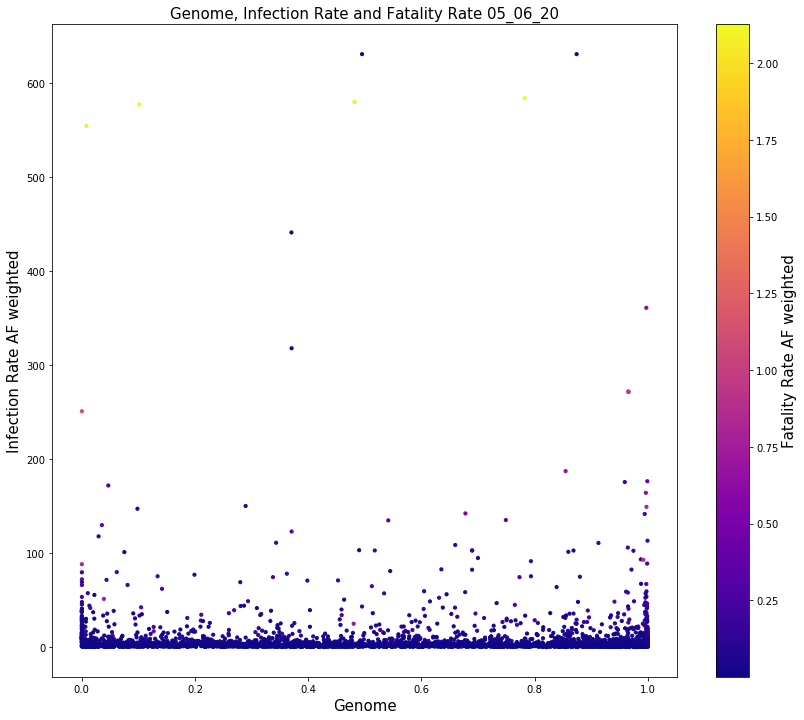

In [210]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
#art = ax.scatter(filt_z['genome']*genome_std+genome_mean,filt_z['infection_rate']*inf_std+inf_mean, s=70, c=filt_z['fatality_rate']*fate_std+fate_mean, cmap='plasma')
art = ax.scatter(filt_z['Start']/29903,filt_z['infection_rate'], s=10, c=filt_z['fatality_rate'], cmap='plasma')

ax.set_xlabel('Genome',fontsize=15)
ax.set_ylabel('Infection Rate AF weighted',fontsize=15)
ax.set_title('Genome, Infection Rate and Fatality Rate 05_06_20',fontsize=15)

# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(ax.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('Fatality Rate AF weighted',fontsize=15)

Text(0, 0.5, 'log Fatality Rate AF weighted')

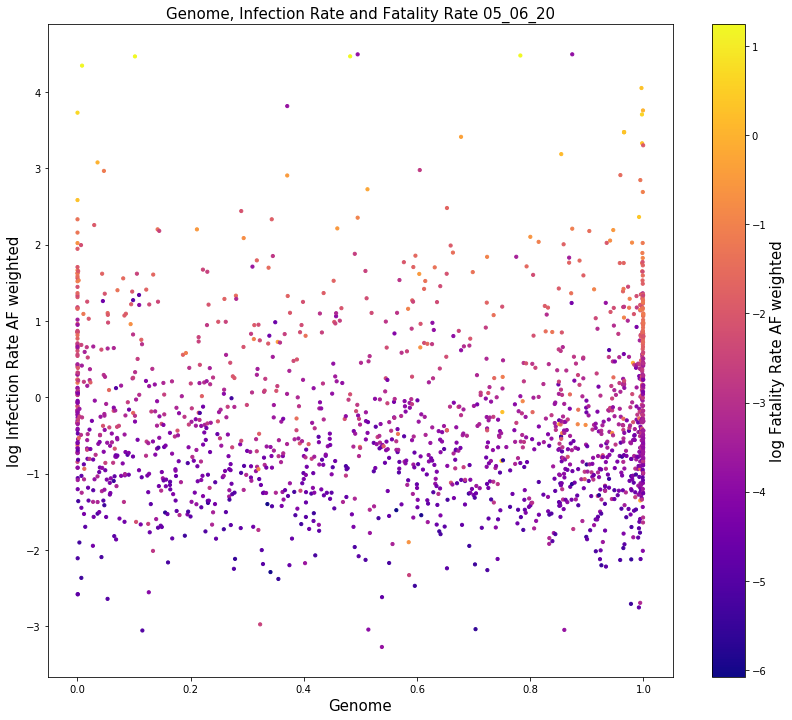

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
#art = ax.scatter(filt_z['genome']*genome_std+genome_mean,filt_z['infection_rate']*inf_std+inf_mean, s=70, c=filt_z['fatality_rate']*fate_std+fate_mean, cmap='plasma')
art = ax.scatter(filt_z['Start']/29903,np.log(filt_z['infection_rate']), s=10, c=np.log(filt_z['fatality_rate']), cmap='plasma')

ax.set_xlabel('Genome',fontsize=15)
ax.set_ylabel('log Infection Rate AF weighted',fontsize=15)
ax.set_title('Genome, Infection Rate and Fatality Rate 05_06_20',fontsize=15)

# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(ax.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('log Fatality Rate AF weighted',fontsize=15)

Text(0, 0.5, 'Fatality Rate AF weighted')

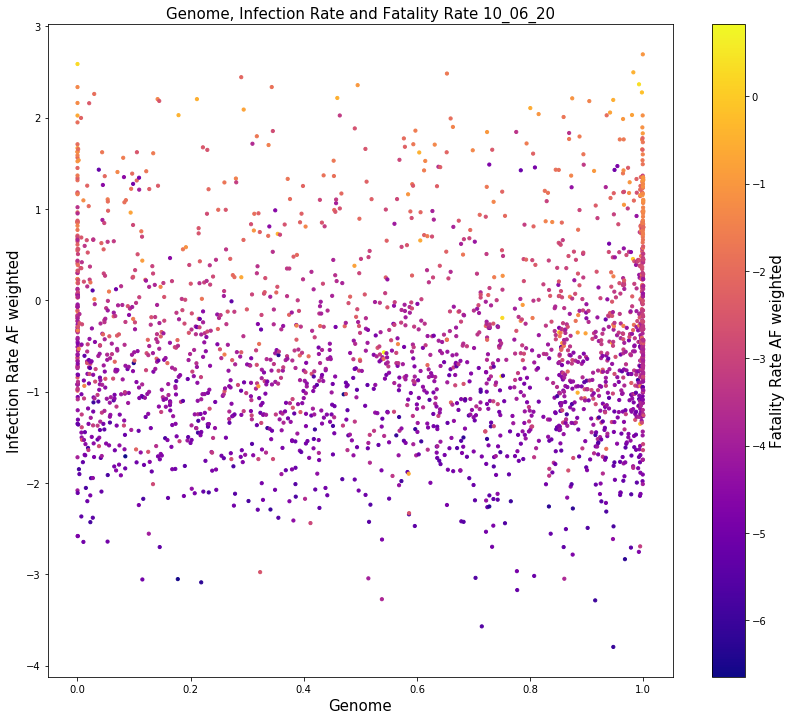

In [205]:
filt_z = pd.read_csv(f"temporal_files/cumulative_daily_AFweighted/10_06_20.csv")
filt_z = filt_z[filt_z['countries']>3]
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
#art = ax.scatter(filt_z['genome']*genome_std+genome_mean,filt_z['infection_rate']*inf_std+inf_mean, s=70, c=filt_z['fatality_rate']*fate_std+fate_mean, cmap='plasma')
art = ax.scatter(filt['Start']/29903,np.log(filt['infection_rate']), s=10, c=np.log(filt['fatality_rate']), cmap='plasma')

ax.set_xlabel('Genome',fontsize=15)
ax.set_ylabel('Infection Rate AF weighted',fontsize=15)
ax.set_title('Genome, Infection Rate and Fatality Rate 10_06_20',fontsize=15)

# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(ax.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('Fatality Rate AF weighted',fontsize=15)

Text(0, 0.5, 'Fatality Rate Count Weighted')

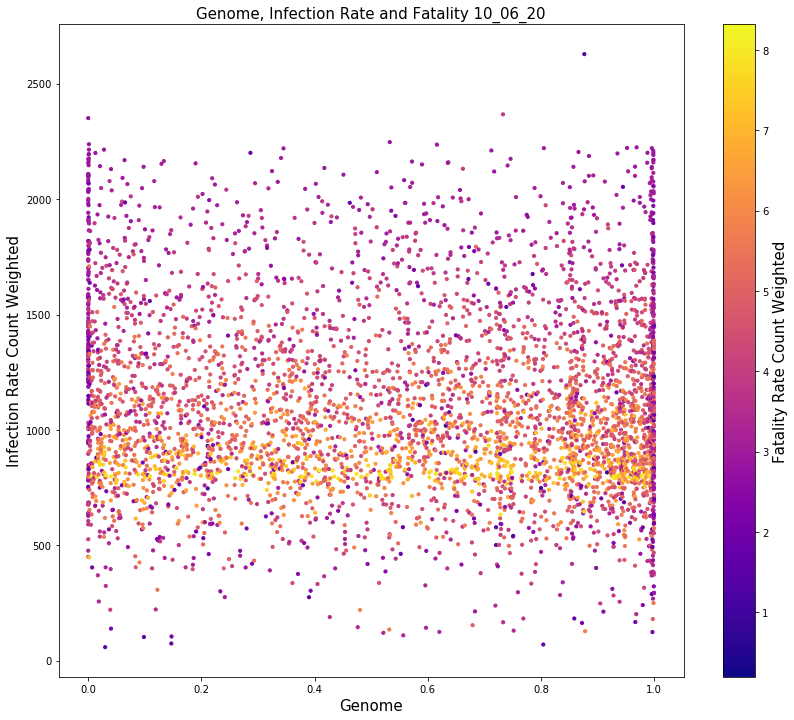

In [194]:
data = pd.read_csv(f"temporal_files/cumulative_daily/10_06_20.csv")
data = data[data['countries']>3]
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
#art = ax.scatter(filt_z['genome']*genome_std+genome_mean,filt_z['infection_rate']*inf_std+inf_mean, s=70, c=filt_z['fatality_rate']*fate_std+fate_mean, cmap='plasma')
art = ax.scatter(data['Start']/29903,data['infection_rate'], s=10, c=data['fatality_rate'], cmap='plasma')

ax.set_xlabel('Genome',fontsize=15)
ax.set_ylabel('Infection Rate Count Weighted',fontsize=15)
ax.set_title('Genome, Infection Rate and Fatality 10_06_20',fontsize=15)

# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(ax.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('Fatality Rate Count Weighted',fontsize=15)

Text(0, 0.5, 'Fatality Rate Count Weighted')

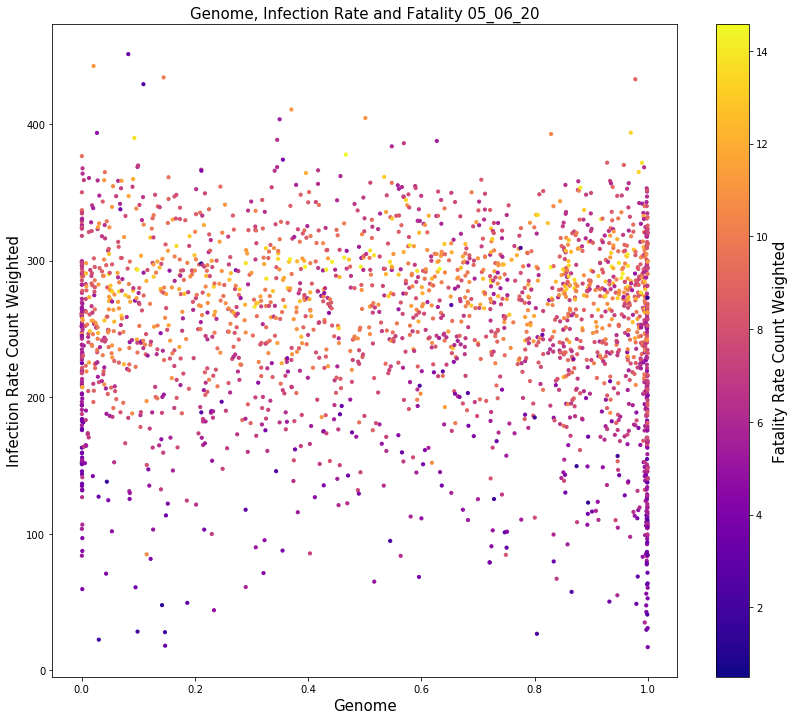

In [195]:
data = pd.read_csv(f"temporal_files/cumulative_daily/05_06_20.csv")
data = data[data['countries']>3]
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
#art = ax.scatter(filt_z['genome']*genome_std+genome_mean,filt_z['infection_rate']*inf_std+inf_mean, s=70, c=filt_z['fatality_rate']*fate_std+fate_mean, cmap='plasma')
art = ax.scatter(data['Start']/29903,data['infection_rate'], s=10, c=data['fatality_rate'], cmap='plasma')

ax.set_xlabel('Genome',fontsize=15)
ax.set_ylabel('Infection Rate Count Weighted',fontsize=15)
ax.set_title('Genome, Infection Rate and Fatality 05_06_20',fontsize=15)

# labeled = filt_z[~filt_z['mutation'].isna()]
# x = labeled['genome'].values
# y = labeled['infection_rate'].values
# label = labeled['mutation'].values
# texts = []
# for i, txt in enumerate(label):
#     texts.append(ax.text(x[i],y[i],txt))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
cbar = plt.colorbar(art);
cbar.ax.set_ylabel('Fatality Rate Count Weighted',fontsize=15)